In [1]:
#@title Import Libraries { vertical-output: true, display-mode: "form" }

#Using LighFM for only Train test splitting
!pip install lightfm

import pandas as pd
import numpy as np
import ast
import gc
from scipy import sparse
import sklearn
sklearn.__version__
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import scale, StandardScaler
from lightfm.cross_validation import random_train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm
from prettytable import PrettyTable
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
from collections import Counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 13.4 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=697438 sha256=b81a8d81c60cf90ffb9ece39db99a7b30a889370041e52af4d6e97eecef294c8
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


# Load Dataset

### Load and filter business dataframe

In [76]:
#@title Load business dataset { display-mode: "form" }

business_df = pd.read_json('/content/drive/MyDrive/yelp_restaurant_recommendation/yelp_academic_dataset_business.json', lines=True)
business_df.shape

(150346, 14)

In [77]:
business_df.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."


Lets see what the 25 top businesses are on Yelp

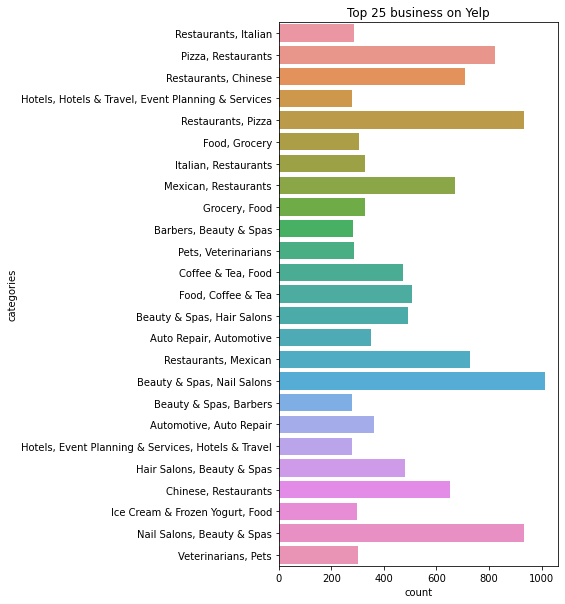

In [78]:
#@title Top 25 business on Yelp { vertical-output: true, display-mode: "form" }
fig, ax = plt.subplots(figsize=[5,10])
sns.countplot(data=business_df[business_df['categories'].isin( business_df['categories'].value_counts().head(25).index)],y='categories', ax=ax)
plt.title('Top 25 business on Yelp')
plt.show()

Filter only Restaurants from business categories

In [79]:
business_df = business_df.drop('hours', axis=1)
business_df = business_df.dropna(axis = 0, how = 'any')
business_df = business_df[business_df['categories'].str.contains('Restaurants')]
business_df.shape

(51703, 13)

In [80]:
business_df.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea..."


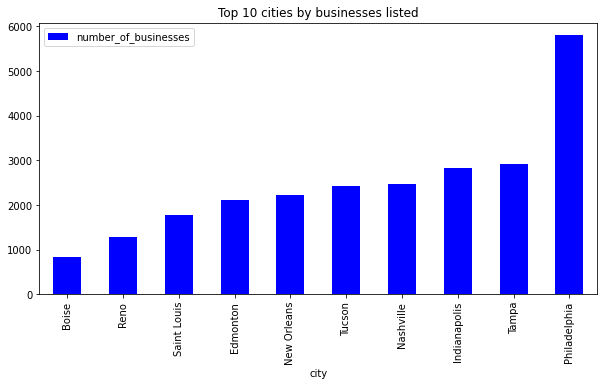

In [81]:
#@title Top 10 cities by number of businesses listed { vertical-output: true, display-mode: "form" }
city_business_counts = business_df[['city', 'business_id']].groupby(['city'])['business_id'].agg('count').sort_values(ascending=False)
city_business_counts = pd.DataFrame(data=city_business_counts)
city_business_counts.rename(columns={'business_id' : 'number_of_businesses'}, inplace=True)
city_business_counts[0:10].sort_values(ascending=True, by="number_of_businesses").plot(kind='bar', stacked=False, figsize=[10,5], colormap='winter')
plt.title('Top 10 cities by businesses listed')
plt.show()

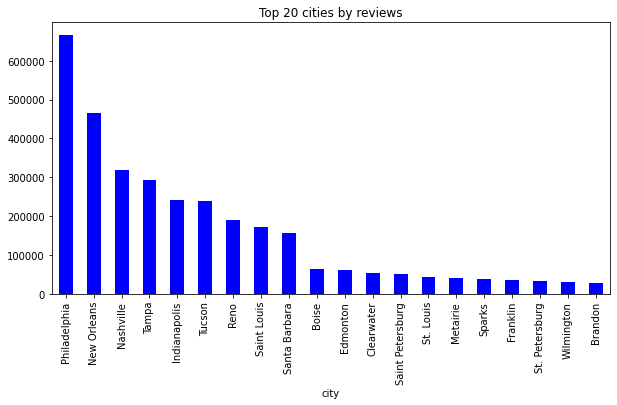

In [82]:
#@title Top 20 cities by reviews { vertical-output: true, display-mode: "form" }
city_business_reviews = business_df[['city', 'review_count', 'stars']].groupby(['city']).agg({'review_count': 'sum', 'stars': 'mean'}).sort_values(by='review_count', ascending=False)
city_business_reviews['review_count'][0:20].plot(kind='bar', stacked=False, figsize=[10,5], colormap='winter')
plt.title('Top 20 cities by reviews')
plt.show()

We won't be recommending restaurants that are no longer open, hence we drop restaurants that are closed.

In [83]:
business_df = business_df[business_df.is_open==1]
business_df.shape

(34547, 13)

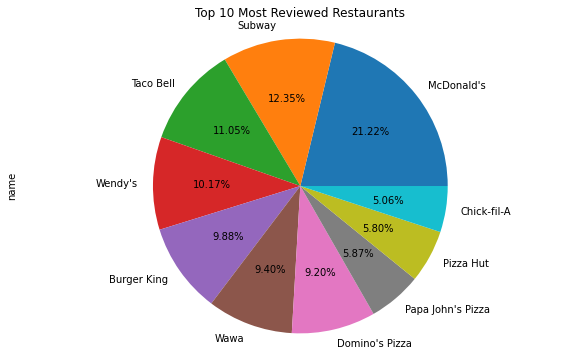

In [84]:
#@title Top 10 most reviewed restaurants { vertical-output: true, display-mode: "form" }
business_df[['name', 'review_count', 'city', 'stars']].sort_values(ascending=False, by="review_count")[0:10]
business_df['name'].value_counts().sort_values(ascending=False).head(10).plot(kind='pie',figsize=(10,6), 
title="Top 10 Most Reviewed Restaurants", autopct='%1.2f%%')
plt.axis('equal')
plt.show()

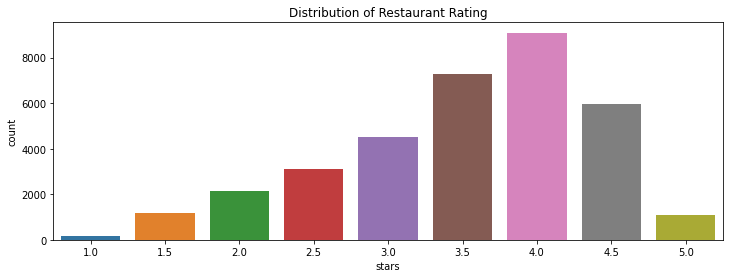

In [11]:
#@title Distribution of Restaurant Rating { vertical-output: true, display-mode: "form" }
plt.figure(figsize=(12,4))
ax = sns.countplot(business_df['stars'])
plt.title('Distribution of Restaurant Rating');

#### Extracting features for restaurants

In [12]:
restaurant_categories_dummies = pd.Series(business_df['categories']).str.get_dummies(',')
restaurant_categories_dummies.head()

,Acai Bowls,Accessories,Accountants,Active Life,Adult,Adult Entertainment,Advertising,Afghan,African,Air Duct Cleaning,...,Whiskey Bars,Wholesale Stores,Wholesalers,Wine Bars,Wine Tasting Room,Wine Tours,Wineries,Women's Clothing,Wraps,Yoga
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here we see there are 1040 features, but some of them are unrelated to restaurants such as Accountants, Accessories, Air Duct cleaning. Lets look for ways to remove them

In [13]:
#Dropping Columns that are 99% values as zero
restaurant_categories_dummies = restaurant_categories_dummies.loc[:, (restaurant_categories_dummies==0).mean()<0.99]
restaurant_categories_dummies.head()

,American (New),American (Traditional),Arts & Entertainment,Asian Fusion,Bakeries,Barbeque,Bars,Beer,Beer Bar,Breakfast & Brunch,...,Fast Food,Food,Italian,Mexican,Nightlife,Pizza,Restaurants,Salad,Sandwiches,Seafood
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


We see the columns are reduced from 1040 to 83, and the columns are related to food/restaurant businesses

In [14]:
def extract_keys(attr, key):
    if attr == None:
        return "{}"
    if key in attr:
        return attr.pop(key)

def str_to_dict(attr):
    if attr != None:
        return ast.literal_eval(attr)
    else:
        return ast.literal_eval("{}")   

Vectorizing attributes column

In [15]:
attributes = business_df[['attributes']]
attributes['BusinessParking'] = attributes.apply(lambda x: str_to_dict(extract_keys(x['attributes'], 'BusinessParking')), axis=1)
attributes['Ambience'] = attributes.apply(lambda x: str_to_dict(extract_keys(x['attributes'], 'Ambience')), axis=1)
attributes['GoodForMeal'] = attributes.apply(lambda x: str_to_dict(extract_keys(x['attributes'], 'GoodForMeal')), axis=1)
attributes['Dietary'] = attributes.apply(lambda x: str_to_dict(extract_keys(x['attributes'], 'Dietary')), axis=1)
attributes['Music'] = attributes.apply(lambda x: str_to_dict(extract_keys(x['attributes'], 'Music')), axis=1)
attributes.head()

,attributes,BusinessParking,Ambience,GoodForMeal,Dietary,Music
3,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","{'garage': False, 'street': True, 'validated':...",{},{},{},{}
5,"{'BusinessAcceptsCreditCards': 'True', 'Restau...",None,None,{},{},{}
9,"{'RestaurantsAttire': ''casual'', 'Restaurants...","{'garage': False, 'street': False, 'validated'...",{},{},{},{}
11,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","{'garage': False, 'street': False, 'validated'...","{'touristy': False, 'hipster': False, 'romanti...","{'dessert': False, 'latenight': False, 'lunch'...",{},{}
12,"{'RestaurantsReservations': 'False', 'Restaura...","{'garage': None, 'street': False, 'validated':...","{'touristy': None, 'hipster': None, 'romantic'...","{'dessert': False, 'latenight': False, 'lunch'...",{},{}


In [16]:
df_attr = pd.concat([ attributes['attributes'].apply(pd.Series), attributes['BusinessParking'].apply(pd.Series),
                    attributes['Ambience'].apply(pd.Series), attributes['GoodForMeal'].apply(pd.Series), 
                    attributes['Dietary'].apply(pd.Series) ], axis=1)
df_attr_dummies = pd.get_dummies(df_attr, drop_first=True)
df_attr_dummies.head()

,RestaurantsDelivery_None,RestaurantsDelivery_True,OutdoorSeating_None,OutdoorSeating_True,BusinessAcceptsCreditCards_None,BusinessAcceptsCreditCards_True,BikeParking_None,BikeParking_True,RestaurantsPriceRange2_2,RestaurantsPriceRange2_3,...,trendy_True,upscale_True,classy_True,casual_True,dessert_True,latenight_True,lunch_True,dinner_True,brunch_True,breakfast_True
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [17]:
#Dropping Columns that are 99% values as zero
df_attr_dummies = df_attr_dummies.loc[:, (df_attr_dummies==0).mean()<0.99]
df_attr_dummies.head()

,RestaurantsDelivery_None,RestaurantsDelivery_True,OutdoorSeating_None,OutdoorSeating_True,BusinessAcceptsCreditCards_True,BikeParking_True,RestaurantsPriceRange2_2,RestaurantsPriceRange2_3,RestaurantsTakeOut_None,RestaurantsTakeOut_True,...,intimate_True,trendy_True,classy_True,casual_True,dessert_True,latenight_True,lunch_True,dinner_True,brunch_True,breakfast_True
3,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,0,1,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
11,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,1,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [18]:
# restaurant_features = pd.concat([restaurant_categories_dummies, df_attr_dummies], axis=1)
# restaurant_features.drop('Restaurants',inplace=True,axis=1)
# restaurant_features.head()

This is the final vectorized restaurant dataframe

In [19]:
restaurant_df = pd.concat([business_df[['business_id', 'name', 'stars']], restaurant_categories_dummies, df_attr_dummies], axis=1)
restaurant_df.head()

,business_id,name,stars,American (New),American (Traditional),Arts & Entertainment,Asian Fusion,Bakeries,Barbeque,Bars,...,intimate_True,trendy_True,classy_True,casual_True,dessert_True,latenight_True,lunch_True,dinner_True,brunch_True,breakfast_True
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,4.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,1.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,il_Ro8jwPlHresjw9EGmBg,Denny's,2.5,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [20]:
restaurant_df.shape

(34547, 145)

In [21]:
del restaurant_categories_dummies
del df_attr_dummies
del attributes

In [22]:
gc.collect()

0

### Load User DataFrame

In [23]:
user_df = pd.DataFrame()
for chunk in pd.read_json('/content/drive/MyDrive/yelp_restaurant_recommendation/yelp_academic_dataset_user.json', chunksize=100000, lines=True):
  # chunk = chunk[chunk['business_id'].isin(business_df['business_id'])]
  user_df = pd.concat([user_df, chunk])
user_df.shape

(1987897, 22)

In order to reduce the number of users, we will select only users who have more than 10 posts tagged as useful are the top 100 most active users

In [24]:
# user_df = user_df[(user_df.useful>10)&(user_df.review_count>200)]
user_df = user_df[(user_df.useful>10)].sort_values(by=['review_count'], ascending=False).head(100)
user_df.shape

(100, 22)

In [25]:
user_df.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
17169,Hi10sGSZNxQH3NLyWSZ1oA,Fox,17473,2009-05-26 11:33:58,206296,185823,195814,"2014,2015,2016,2017,2018,2019,20,20,2021","uZcWE40gWJHjLT_VyNBp1Q, N52nbyDKZte4PUfJVNpkGQ...",3493,...,431,402,130,45,2408,6565,7655,7655,1644,4053
795339,8k3aO-mPeyhbR5HUucA5aA,Victor,16978,2007-12-08 14:56:45,152979,84992,125516,"2008,2009,2010,2011,2012,2013,2014,2015,2016,2...","Isb9ZKTK4L5nkOpyXypDPQ, d3rfsXGWtS7fpGsYfy_C7Q...",1462,...,327,222,55,84,2204,3786,3618,3618,2731,256
4723,hWDybu_KvYLSdEFzGrniTw,Bruce,16567,2009-03-08 21:47:44,173089,98459,144849,"2010,2011,2012,2013,2014,2015,2016,2017,2018,2...","sZ0Qxjn12H8jjHBPLQW32w, Lkk3DqzhvqwpiQKwwAyZcw...",867,...,586,541,34,76,2466,5264,6728,6728,5811,2224
606393,RtGqdDBvvBCjcu5dUqwfzA,Shila,12868,2010-10-17 06:35:06,11109,3747,3292,"2012,2013,2014,2015,2016,2017,2018,2019,20,20,...","hz79Mq7EGhHXZkIspAQtrg, LJE8g5sbnmu5Ua9YGN9SKw...",300,...,20,3,8,7,146,175,173,173,97,11
152,P5bUL3Engv-2z6kKohB6qQ,Kim,9941,2006-05-31 21:27:42,27549,10772,21375,"2006,2007,2008,2009,2010,2011,2012,2013,2014,2...","hfY2Soz8LWSA0oRVcYuRmg, Y6_gZa4jVXv0d4qiMbbycw...",825,...,130,113,47,34,511,1073,1199,1199,482,252


### Load checkin dataset

In [26]:
checkin_df = pd.read_json('/content/drive/MyDrive/yelp_restaurant_recommendation/yelp_academic_dataset_checkin.json', lines=True)
checkin_df.head(2)

,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."


In [27]:
checkin_df.shape

(131930, 2)

### Load Tip Dataset

In [28]:
tip_df = pd.read_json('/content/drive/MyDrive/yelp_restaurant_recommendation/yelp_academic_dataset_tip.json', lines=True)
tip_df.head(2)

,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0


## Load Review dataset

In [29]:
#Loading in chunks due to OOM error
review_df = pd.DataFrame()
for chunk in pd.read_json('/content/drive/MyDrive/yelp_restaurant_recommendation/yelp_academic_dataset_review.json', chunksize=100000, lines=True):
  chunk = chunk[(chunk['business_id'].isin(restaurant_df['business_id']))&(chunk['user_id'].isin(user_df['user_id']))]
  review_df = pd.concat([review_df, chunk])

In [30]:
review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
197,IJCYT9dRjuBvY-BJufFnNg,hWDybu_KvYLSdEFzGrniTw,roc-xyyzN5b_nImb0NdRLQ,4,6,5,5,"As airport grab-and-go restaurants are, Earl d...",2015-01-03 23:16:09
457,nhfB-ssDwJxbpAUjlE889A,fr1Hz2acAb3OaL3l6DyKNg,t-bcEvAM8oE92tm9HBr7wQ,3,8,3,9,We have big group of 12 for the office outing ...,2017-05-26 03:20:52
605,7Ki1tkHP23P2i--9qsTRdg,-G7Zkl1wIWBBmD0KRy_sCw,IbndcMURguByburM72o3SA,5,9,6,4,"Just finished a State Street Kitchen, Grilled ...",2013-10-24 18:13:21
876,XJwl30x7X22v2aKH4Q7GBQ,_BcWyKQL16ndpBdggh2kNA,bJAY2baMKSTlWRc-QZGopQ,3,2,2,1,I like the Neuvo-Latino-Americano grub here. ...,2008-12-04 13:49:58
1097,iKnhnbJddNr00KdFGIRofg,8RcEwGrFIgkt9WQ35E6SnQ,pSmOH4a3HNNpYM82J5ycLA,3,2,1,0,"Still running on EST, we arrived @8:30 on a Sa...",2015-01-19 00:13:48


In [31]:
review_df.shape

(8104, 9)

# Create User-Item matrix

In [32]:
#Create mappers
user_id_map = {id:data for id, data in enumerate(review_df.user_id.unique())}
restaurant_id_map = {id:data for id, data in enumerate(review_df.business_id.unique())}

inv_user_id_map = {id:idx for idx, id in user_id_map.items()}
inv_restaurant_id_map = {id:idx for idx, id in restaurant_id_map.items()}

In [33]:
review_df['business_idx'] = review_df['business_id'].map(inv_restaurant_id_map)
review_df['user_idx'] = review_df['user_id'].map(inv_user_id_map)
review_df.head()


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,business_idx,user_idx
197,IJCYT9dRjuBvY-BJufFnNg,hWDybu_KvYLSdEFzGrniTw,roc-xyyzN5b_nImb0NdRLQ,4,6,5,5,"As airport grab-and-go restaurants are, Earl d...",2015-01-03 23:16:09,0,0
457,nhfB-ssDwJxbpAUjlE889A,fr1Hz2acAb3OaL3l6DyKNg,t-bcEvAM8oE92tm9HBr7wQ,3,8,3,9,We have big group of 12 for the office outing ...,2017-05-26 03:20:52,1,1
605,7Ki1tkHP23P2i--9qsTRdg,-G7Zkl1wIWBBmD0KRy_sCw,IbndcMURguByburM72o3SA,5,9,6,4,"Just finished a State Street Kitchen, Grilled ...",2013-10-24 18:13:21,2,2
876,XJwl30x7X22v2aKH4Q7GBQ,_BcWyKQL16ndpBdggh2kNA,bJAY2baMKSTlWRc-QZGopQ,3,2,2,1,I like the Neuvo-Latino-Americano grub here. ...,2008-12-04 13:49:58,3,3
1097,iKnhnbJddNr00KdFGIRofg,8RcEwGrFIgkt9WQ35E6SnQ,pSmOH4a3HNNpYM82J5ycLA,3,2,1,0,"Still running on EST, we arrived @8:30 on a Sa...",2015-01-19 00:13:48,4,4


In [34]:
review_df.isna().sum()

review_id       0
user_id         0
business_id     0
stars           0
useful          0
funny           0
cool            0
text            0
date            0
business_idx    0
user_idx        0
dtype: int64

In [35]:
review_df['stars'] = review_df.stars.astype('int32')
review_df['user_idx'] = review_df.user_idx.astype('int32')
review_df['business_idx'] = review_df.business_idx.astype('int32')

review_df.dtypes

review_id               object
user_id                 object
business_id             object
stars                    int32
useful                   int64
funny                    int64
cool                     int64
text                    object
date            datetime64[ns]
business_idx             int32
user_idx                 int32
dtype: object

In [36]:
n_users = len(user_id_map)
n_items = len(restaurant_id_map)
print(n_users, n_items)

95 5736


In [37]:
review_df.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,business_idx,user_idx
197,IJCYT9dRjuBvY-BJufFnNg,hWDybu_KvYLSdEFzGrniTw,roc-xyyzN5b_nImb0NdRLQ,4,6,5,5,"As airport grab-and-go restaurants are, Earl d...",2015-01-03 23:16:09,0,0
457,nhfB-ssDwJxbpAUjlE889A,fr1Hz2acAb3OaL3l6DyKNg,t-bcEvAM8oE92tm9HBr7wQ,3,8,3,9,We have big group of 12 for the office outing ...,2017-05-26 03:20:52,1,1


In [38]:
ratings = review_df.pivot_table(values='stars', index ='user_idx', columns='business_idx')
ratings = sparse.csr_matrix(ratings.fillna(0).values)
ratings.shape

(95, 5736)

In [40]:
sparsity = ratings.getnnz()
sparsity /= (n_items * n_users)
sparsity *= 100
print (f'Sparsity: {sparsity}')

Sparsity: 1.3695588343243046


# Create Similarity matrix
For similarity, we are using Cosine similarity

In [41]:
item_similarity = cosine_similarity(ratings.transpose())
item_similarity.shape

(5736, 5736)

In [42]:
def k_similar_restaurants(similarity, restaurant_idx, mapper=restaurant_id_map, k=6):
    # similarity = np.argsort(similarity[restaurant_idx,:])[:-k-1:-1]
    return [mapper[x] for x in np.argsort(similarity[restaurant_idx,:])[:-k-1:-1]], np.sort(similarity[restaurant_idx,:])[:-k-1:-1]
  
def show_similar_restaurants(dataframe, similarity, restaurant_idx, mapper=restaurant_id_map, k=6):
    id, sim = k_similar_restaurants(similarity, restaurant_idx, mapper, k)
    new_df = dataframe[dataframe.business_id.isin(id)][['business_id', 'name', 'attributes','categories']].set_index('business_id').reindex(id)
    # new_df['similarity'] = sim
    return new_df

In [43]:
#@title Get restaurants similar to restaurant_idx { display-mode: "form" }
restaurant_idx = 99#@param {type:"number"}
show_similar_restaurants(business_df, item_similarity, restaurant_idx = 99)

,name,attributes,categories
business_id,,,
2bvABSVn-kChNn0I4BrRJQ,Burger King,"{'NoiseLevel': 'u'average'', 'RestaurantsAttir...","Burgers, Fast Food, Restaurants"
UrWsPqcJFlf5sGVRZzsuYw,Dunkin',"{'BikeParking': 'False', 'BusinessAcceptsCredi...","Donuts, Coffee & Tea, Restaurants, Food"
JBW6XSJQTcCmCFRnUYfJMw,Chicken Now,"{'OutdoorSeating': 'False', 'HasTV': 'True', '...","American (New), Food, Chicken Wings, Restaurants"
kLMhzlzK1b5ohWRMJNmwKw,Nino's Trattoria & Pizzeria,"{'RestaurantsTakeOut': 'True', 'OutdoorSeating...","Steakhouses, Burgers, Restaurants, Pizza, Hot ..."
PJjkH_VZeQwxEJvlQ-v7wA,Pho 75,"{'NoiseLevel': 'u'average'', 'RestaurantsAttir...","Restaurants, Asian Fusion, Vietnamese"
E8RHLvnRi_76ryF9lOHoJA,Valentino's,"{'RestaurantsTakeOut': 'True', 'OutdoorSeating...","Pizza, Restaurants, Food"


The above dataframe shows similar restaurants to idx=99 ie Burger King (first row of the dataframe). We can aproximate this similarity from the columns 'attributes' and 'categories'. We see that the restaurants recommends fast-food places in categories such as  pizzas, burgers and donuts and with similar attributes such as noiseLevel:average and RestaurantTakeOut as True

# Build a CF-based Recommender system using Stochastic Gradient Descent

## Create train-test dataset

In [44]:
train, val = random_train_test_split(ratings, test_percentage=0.2, random_state=24)

In [45]:
train = train.tocsr()
val = val.tocsr()

In [46]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].reshape(-1,1)
    ground_truth = ground_truth[ground_truth.nonzero()].reshape(-1,1)
    # print(prediction.shape, ground_truth.shape)
    return sqrt(mean_squared_error(prediction, ground_truth))

## Build Recommender System


### Recommendation System using randomly initialized latent vectors
Here we are randomly initializing the latent features and train them by stochastic gradient descent

In [47]:
class Recommender:
  
  def __init__(self, n_epochs=200, n_latent_features=3, lmbda=0.1, learning_rate=0.001):
    self.n_epochs = n_epochs
    self.n_latent_features = n_latent_features
    self.lmbda = lmbda
    self.learning_rate = learning_rate
  
  def predictions(self, P, Q):
    return np.dot(P.T, Q)
  
  def fit(self, X_train, X_val):
    m, n = X_train.shape

    self.P = 3 * np.random.rand(self.n_latent_features, m)
    self.Q = 3 * np.random.rand(self.n_latent_features, n)
    
    self.train_error = []
    self.val_error = []

    users, items = X_train.nonzero()
    
    for epoch in tqdm(range(self.n_epochs)):
        for u, i in zip(users, items):
            error = X_train[u, i] - self.predictions(self.P[:,u], self.Q[:,i])
            self.P[:, u] += self.learning_rate * (error * self.Q[:, i] - self.lmbda * self.P[:, u])
            self.Q[:, i] += self.learning_rate * (error * self.P[:, u] - self.lmbda * self.Q[:, i])

        train_rmse = rmse(self.predictions(self.P, self.Q), X_train)
        val_rmse = rmse(self.predictions(self.P, self.Q), X_val)

        self.train_error.append(train_rmse)
        self.val_error.append(val_rmse)
        
    return self
  
  def predict(self, X_train, user_index):
    y_hat = self.predictions(self.P, self.Q)
    predictions_index = sparse.find(X_train[user_index, :] == 0)[1]
    return predictions_index, np.clip(y_hat[user_index, predictions_index].flatten(),0,5)

In [48]:
recommender = Recommender(n_epochs=200, n_latent_features=5, lmbda=0.1, learning_rate=0.0002).fit(train, val)

100%|██████████| 200/200 [00:56<00:00,  3.55it/s]


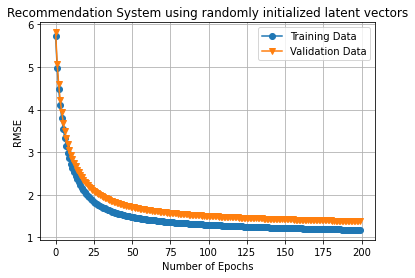

In [72]:
plt.plot(range(recommender.n_epochs), recommender.train_error, marker='o', label='Training Data');
plt.plot(range(recommender.n_epochs), recommender.val_error, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.title("Recommendation System using randomly initialized latent vectors")
plt.show()

In [50]:
print(f"The RMSE is {str(round(recommender.val_error[-1],2))} at {str(recommender.n_epochs)} epoch") 

The RMSE is 1.38 at 200 epoch


#### Making recommendations

In [52]:
#@title Enter User index to make recommendations. { display-mode: "form" }

user_index = 10 #@param {type:"number"}
number_of_recommendations =  5#@param {type:"number"}
def display_user_restaurants(indexes, ratings, dataframe, mapper=restaurant_id_map, k=10):
    max_ratings_idx = np.argsort(ratings)[-k:]
    id = np.vectorize(mapper.get)(indexes[max_ratings_idx])
    new_df = business_df[business_df.business_id.isin(id)][['business_id', 'name', 'attributes','categories']].set_index('business_id').reindex(id)
    # new_df['ratings'] = ratings[max_ratings_idx]
    return new_df[[ 'name','attributes','categories']]

predicted_idx, predicted_ratings = recommender.predict(train, user_index)
display_user_restaurants(predicted_idx, predicted_ratings, business_df, k=number_of_recommendations)

,name,attributes,categories
business_id,,,
6tsO4gM97pjPaed6lJ1GuQ,Jersey Mike's Subs,"{'RestaurantsAttire': 'u'casual'', 'HasTV': 'T...","Delis, Fast Food, Restaurants, Sandwiches"
3tf6oHkhN22mqFNMSPsZlQ,Flying M Coffeehouse,"{'WiFi': ''free'', 'BusinessAcceptsCreditCards...","Shopping, Food, Flowers & Gifts, Bakeries, Cof..."
rYqmaOIULRouz_1db07OdQ,Green Eggs Cafe,"{'BusinessAcceptsCreditCards': 'False', 'WiFi'...","Diners, Restaurants, Breakfast & Brunch, Ameri..."
VAIOtbsxdNmuhUKkQZFRlA,Renaud's Patisserie & Bistro,"{'GoodForKids': 'True', 'RestaurantsAttire': '...","French, Cafes, Restaurants, Breakfast & Brunch..."
3oPF146et-MbsPADAHkXYg,Chick-fil-A,"{'OutdoorSeating': 'False', 'Alcohol': 'u'none...","Fast Food, Caterers, Chicken Shop, American (T..."


In [53]:
#@title Top k restaurants the user rated. { display-mode: "form" }
k = 5#@param {type:"number"}
existing_ratings_index = train[user_index, :].nonzero()[1]
existing_ratings = train[user_index, existing_ratings_index].toarray().flatten()
display_user_restaurants(existing_ratings_index, existing_ratings, business_df, k=k)

,name,attributes,categories
business_id,,,
pdLlJu-oOdy4gW_6rwuEQQ,Tony's of Indianapolis,"{'GoodForKids': 'False', 'WheelchairAccessible...","Nightlife, Restaurants, Seafood, Steakhouses, ..."
CRl3c9JpUFA5gCbLWUPgqw,Nigh Brewing,"{'ByAppointmentOnly': 'False', 'DogsAllowed': ...","Restaurants, Food, Brewpubs, Breweries"
IG2KelKEHCwybPl98frdgQ,La Parada,"{'RestaurantsPriceRange2': '1', 'RestaurantsAt...","Seafood, Local Flavor, Restaurants, Nightlife,..."
SqkBIkfYOkwJrdehXBvVIQ,Chris' Ice Cream,"{'RestaurantsReservations': 'False', 'BikePark...","Food, Restaurants, Ice Cream & Frozen Yogurt, ..."
K96eX9tL3nsfuEJcNYNVQA,Greek's Pizzeria,"{'RestaurantsPriceRange2': '2', 'RestaurantsDe...","Nightlife, Pizza, Bars, Restaurants, Beer Bar"


### Recommendation System using Restaurant features
In the previous recommendation system, we randomly initialized the latent features. In this recommendation system, we will use a static restaurant feature and use gradient descent to create user embeddings.

In [54]:
restaurant_df = restaurant_df[restaurant_df.business_id.isin(inv_restaurant_id_map.keys())]
restaurant_df.head()

,business_id,name,stars,American (New),American (Traditional),Arts & Entertainment,Asian Fusion,Bakeries,Barbeque,Bars,...,intimate_True,trendy_True,classy_True,casual_True,dessert_True,latenight_True,lunch_True,dinner_True,brunch_True,breakfast_True
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,4.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
19,ROeacJQwBeh05Rqg7F6TCg,BAP,4.5,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
61,seKihQKpGGnCeLuELRQPSQ,Twin Peaks,3.5,1,1,0,0,0,0,1,...,0,0,0,1,0,0,1,1,0,0
79,pJfh3Ct8iL58NZa8ta-a5w,Top Shelf Sports Lounge,4.5,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
82,ppFCk9aQkM338Rgwpl2F5A,Wawa,3.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [55]:
restaurant_df['business_idx']=restaurant_df.business_id.map(inv_restaurant_id_map)
restaurant_df = restaurant_df.set_index('business_idx').sort_index()
restaurant_df.head()

,business_id,name,stars,American (New),American (Traditional),Arts & Entertainment,Asian Fusion,Bakeries,Barbeque,Bars,...,intimate_True,trendy_True,classy_True,casual_True,dessert_True,latenight_True,lunch_True,dinner_True,brunch_True,breakfast_True
business_idx,,,,,,,,,,,,,,,,,,,,,
0,roc-xyyzN5b_nImb0NdRLQ,Earl of Sandwich,3.5,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
1,t-bcEvAM8oE92tm9HBr7wQ,Petra Restaurant,4.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,IbndcMURguByburM72o3SA,State Street Kitchen,4.5,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,1
3,bJAY2baMKSTlWRc-QZGopQ,Lilly's Cafe America,3.5,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,pSmOH4a3HNNpYM82J5ycLA,The Pancake Pantry,4.0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,1,1


In [56]:
restaurant_features = restaurant_df.drop(['business_id','name','stars'], axis=1)
restaurant_features.head()

,American (New),American (Traditional),Arts & Entertainment,Asian Fusion,Bakeries,Barbeque,Bars,Beer,Beer Bar,Breakfast & Brunch,...,intimate_True,trendy_True,classy_True,casual_True,dessert_True,latenight_True,lunch_True,dinner_True,brunch_True,breakfast_True
business_idx,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,1,...,0,0,1,1,0,0,0,0,1,1


Create custom recommender for static restaurant features
Here, with every epoch, the restaurant features will not be updated with gradient descent

In [57]:
class Custom_Recommender:
  
  def __init__(self, item_features, n_epochs=200, lmbda=0.1, learning_rate=0.001):
    self.n_epochs = n_epochs
    self.Q = item_features.T
    self.n_latent_features = self.Q.shape[0]
    self.lmbda = lmbda
    self.learning_rate = learning_rate
  
  def predictions(self, P, Q):
    return np.dot(P.T, Q)
  
  def fit(self, X_train, X_val):
    m, n = X_train.shape

    self.P = 3 * np.random.rand(self.n_latent_features, m)
    # self.Q = 3 * np.random.rand(self.n_latent_features, n)
    
    self.train_error = []
    self.val_error = []

    users, items = X_train.nonzero()
    
    for epoch in tqdm(range(self.n_epochs)):
        for u, i in zip(users, items):
            error = X_train[u, i] - self.predictions(self.P[:,u], self.Q[:,i])
            self.P[:, u] += self.learning_rate * (error * self.Q[:, i] - self.lmbda * self.P[:, u])
            # self.Q[:, i] += self.learning_rate * (error * self.P[:, u] - self.lmbda * self.Q[:, i])

        train_rmse = rmse(self.predictions(self.P, self.Q), X_train)
        val_rmse = rmse(self.predictions(self.P, self.Q), X_val)

        self.train_error.append(train_rmse)
        self.val_error.append(val_rmse)
        
    return self
  
  def predict(self, X_train, user_index):
    y_hat = self.predictions(self.P, self.Q)
    predictions_index = sparse.find(X_train[user_index, :] == 0)[1]
    return predictions_index, np.clip(y_hat[user_index, predictions_index].flatten(),0,5)

In [58]:
recommender_1 = Custom_Recommender(n_epochs=500, item_features =restaurant_features.values, lmbda=0.1, learning_rate=0.0001).fit(train, val)

100%|██████████| 500/500 [02:15<00:00,  3.70it/s]


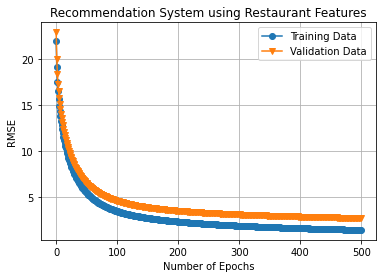

In [71]:
plt.plot(range(recommender_1.n_epochs), recommender_1.train_error, marker='o', label='Training Data');
plt.plot(range(recommender_1.n_epochs), recommender_1.val_error, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.title("Recommendation System using Restaurant Features")
plt.show()

In [60]:
print(f"The min RMSE is {str(round(recommender_1.val_error[-1],2))} at {str(recommender_1.n_epochs)} epoch") 


The min RMSE is 2.74 at 500 epoch


### Using PCA on restaurant features
The restaurants have 141 features which would create a large sparse embedding, hence we will reduce it by using PCA on the features

In [61]:
pca = PCA(n_components=5, random_state=24)
pca_features = pca.fit_transform(restaurant_features)

In [62]:
recommender_2 = Custom_Recommender(n_epochs=500, item_features =pca_features, lmbda=0.1, learning_rate=0.0001).fit(train, val)

100%|██████████| 500/500 [02:30<00:00,  3.33it/s]


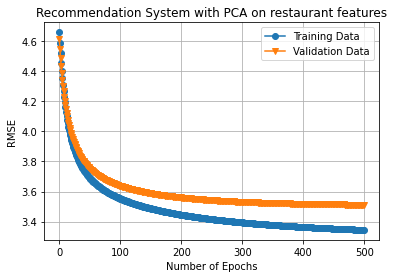

In [73]:
plt.plot(range(recommender_2.n_epochs), recommender_2.train_error, marker='o', label='Training Data');
plt.plot(range(recommender_2.n_epochs), recommender_2.val_error, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.title("Recommendation System with PCA on restaurant features")
plt.grid()
plt.show()

In [64]:
print(f"The min RMSE is {str(round(recommender_2.val_error[-1],2))} at {str(recommender_2.n_epochs)} epoch") 


The min RMSE is 3.51 at 500 epoch


#### Making recommendations

In [65]:
#@title Enter User index to make recommendations. { display-mode: "form" }

user_index = 10 #@param {type:"number"}
number_of_recommendations =  5#@param {type:"number"}
def display_user_restaurants(indexes, ratings, dataframe, mapper=restaurant_id_map, k=10):
    max_ratings_idx = np.argsort(ratings)[-k:]
    id = np.vectorize(mapper.get)(indexes[max_ratings_idx])
    new_df = business_df[business_df.business_id.isin(id)][['business_id', 'name', 'attributes','categories']].set_index('business_id').reindex(id)
    # new_df['ratings'] = ratings[max_ratings_idx]
    return new_df[[ 'name','attributes','categories']]

predicted_idx, predicted_ratings = recommender_2.predict(train, user_index)
display_user_restaurants(predicted_idx, predicted_ratings, business_df, k=number_of_recommendations)

,name,attributes,categories
business_id,,,
5DJ2sDvM_XRndlB24DnxYw,Adele's,"{'Alcohol': 'u'full_bar'', 'NoiseLevel': 'u'av...","Cocktail Bars, Restaurants, American (New), Ev..."
Hh8jUR0mtVXkAnv8XDZjyA,Sierra St Kitchen & Cocktails,"{'RestaurantsTakeOut': 'True', 'BestNights': '...","Bars, Nightlife, Restaurants, Wine Bars, Salad..."
Z8c0t6xPfM8u1H1ZUcWlOw,Anzie Blue,"{'OutdoorSeating': 'True', 'DogsAllowed': 'Tru...","Cafes, Cocktail Bars, Cosmetics & Beauty Suppl..."
JSjKDbPTsv4mWd3P5nRkfw,Water's Edge Gastropub and Lounge,"{'WiFi': 'u'free'', 'Alcohol': 'u'full_bar'', ...","Bartenders, Venues & Event Spaces, Lounges, Am..."
tavK8PX3ysc8DRFEB8AlTA,Quality Foods Market,"{'WiFi': 'u'free'', 'HasTV': 'True', 'DogsAllo...","Salad, Grocery, Specialty Food, Delis, Food, B..."


In [66]:
#@title Top k restaurants the user rated. { display-mode: "form" }
k = 5#@param {type:"number"}
existing_ratings_index = train[user_index, :].nonzero()[1]
existing_ratings = train[user_index, existing_ratings_index].toarray().flatten()
display_user_restaurants(existing_ratings_index, existing_ratings, business_df, k=k)

,name,attributes,categories
business_id,,,
pdLlJu-oOdy4gW_6rwuEQQ,Tony's of Indianapolis,"{'GoodForKids': 'False', 'WheelchairAccessible...","Nightlife, Restaurants, Seafood, Steakhouses, ..."
CRl3c9JpUFA5gCbLWUPgqw,Nigh Brewing,"{'ByAppointmentOnly': 'False', 'DogsAllowed': ...","Restaurants, Food, Brewpubs, Breweries"
IG2KelKEHCwybPl98frdgQ,La Parada,"{'RestaurantsPriceRange2': '1', 'RestaurantsAt...","Seafood, Local Flavor, Restaurants, Nightlife,..."
SqkBIkfYOkwJrdehXBvVIQ,Chris' Ice Cream,"{'RestaurantsReservations': 'False', 'BikePark...","Food, Restaurants, Ice Cream & Frozen Yogurt, ..."
K96eX9tL3nsfuEJcNYNVQA,Greek's Pizzeria,"{'RestaurantsPriceRange2': '2', 'RestaurantsDe...","Nightlife, Pizza, Bars, Restaurants, Beer Bar"


# Comparison of CF-based recommender system

In [67]:
x = PrettyTable()
x.field_names = ["Sr. no.","CF Recommender type","RMSE"]
x.add_row([1, 'CF Recommender using randomly initialized latent vectors',round(recommender.val_error[-1],2)])
x.add_row([2, 'CF Recommender using restaurant features',round(recommender_1.val_error[-1],2)])
x.add_row([3, 'CF Recommender with PCA on restaurant features',round(recommender_2.val_error[-1],2)])
print(x)

+---------+----------------------------------------------------------+------+
| Sr. no. |                   CF Recommender type                    | RMSE |
+---------+----------------------------------------------------------+------+
|    1    | CF Recommender using randomly initialized latent vectors | 1.38 |
|    2    |         CF Recommender using restaurant features         | 2.74 |
|    3    |      CF Recommender with PCA on restaurant features      | 3.51 |
+---------+----------------------------------------------------------+------+


# Further Analysis

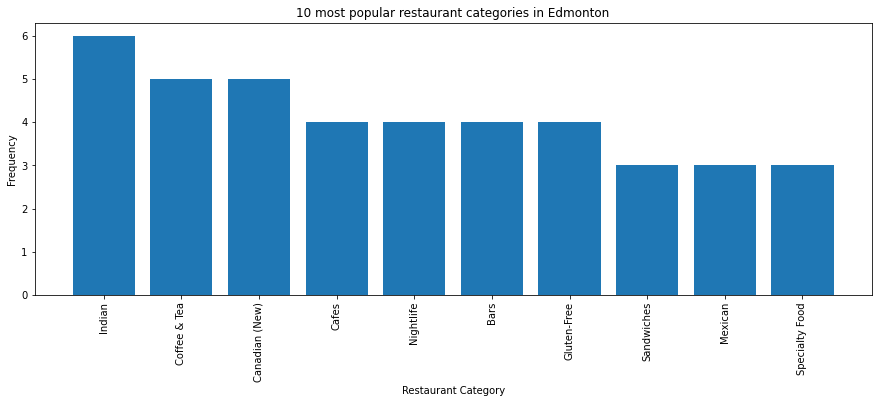

In [68]:
#@title 10 most popular restaurant categories in the city { vertical-output: true, display-mode: "form" }
city = 'Edmonton'#@param {type:"string"}
plt.figure(figsize=(15,5))

top_25_business = business_df[business_df.city==city].sort_values(['stars', 'review_count'], ascending=[False, False]).head(25)
categories = []
for i in top_25_business.categories:
  categories.extend(j.strip() for j in i.split(','))
counter = Counter(categories)
del counter['Restaurants']
del counter['Food']
counter = counter.most_common()[:10]
plt.bar([c for c, _ in counter], [c for  _, c in counter])
plt.title(f"10 most popular restaurant categories in {city}")
plt.xlabel("Restaurant Category")
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.show()

Try Cities 'Philadelphia' and 'Edmonton'.

We observe the differences in the popular restaurant categories of the area. In Philadelphia sandwiches, mexican and italian foods are more popular whereas in Edmonton Indian food, cafes and canadian food are more popular. Thus the popularity of a new restaurant in a city can be estimated by the category of the restaurant 